In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob
import dateutil
import datetime

## utility functions

In [12]:
def days_range(start_date, end_date):
    days = []
    start_date = dateutil.parser.parse(start_date)
    end_date = dateutil.parser.parse(end_date)

    while start_date < end_date:
        days.append(start_date)
        start_date += datetime.timedelta(days=1)

    days.append(end_date)
    return days

def cumulative_to_daily(data):
    return data[1:] - data[:-1]

## load twitter statistics

In [13]:
def get_date_by_filename(file):
    return file.split('/')[-1].split('.')[0]

def load_statistics(file):
    with open(file, 'r') as f:
        stats = json.load(f)
        
    return stats

def files_to_dataframe(files):
    stats = [load_statistics(f) for f in files]
    dates = [get_date_by_filename(f) for f in files]
    
    unique_dates = list(set(dates))
    
    merged_data = {}
    
    def update(date, stats):
        for country, tweets_count in stats.items():
            country_dict = merged_data.get(country, {})
            country_dict[date] = country_dict.get(date, 0) + tweets_count
            merged_data[country] = country_dict
    
    for d, s in zip(dates, stats):
        update(d, s)
        
    countries = list(merged_data.keys())
    df_dict = {'Alpha2': countries}
    
    for date in unique_dates:
        daily_stats = [merged_data[country][date] for country in countries]
        df_dict[date] = daily_stats
        
    df = pd.DataFrame.from_dict(df_dict)
    df = df.set_index('Alpha2')
    df = df.reindex(sorted(df.columns), axis=1)
    return df

class TwitterDataLoader:
    def __init__(self, data_dir):
        files = sorted(glob.glob(twitter_data_source + '*/*.json'))
        self.df = files_to_dataframe(files)
        
    def get_data(self, country_code, days=None):
        country_record = self.df.loc[country_code]
        
        if days is None:
            return country_record
        
        days = days_range(*days)
        days_str = [day.strftime("%Y-%m-%d") for day in days]
        return country_record[days_str]
        

In [14]:
# directory with daily statistics files
twitter_data_source = './data/twitter/'
twitter_data = TwitterDataLoader(twitter_data_source)

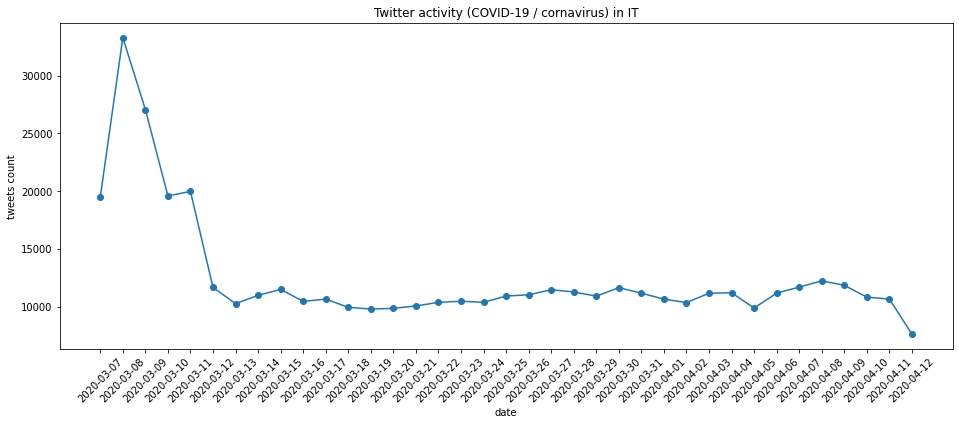

In [15]:
start_date = '8 mar 2020'
end_date = '10 jul 2020'
country = 'IT'

data = twitter_data.get_data(country)#, (start_date, end_date))

plt.figure(figsize=(16, 6))
plt.plot(data, 'o-')

plt.title(f'Twitter activity (COVID-19 / cornavirus) in {country}')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel(f'tweets count')

plt.show()

## load who statistics

In [19]:
def load_who_csv(file):
    df = pd.read_csv(file)
    
    if start_date is not None:
        days = []
        start_date = dateutil.parser.parse(start_date)
        end_date = dateutil.parser.parse(end_date)
        
        while start_date < end_date:
            days.append(start_date)
            start_date += datetime.timedelta(days=1)
            
        days.append(end_date)
        
        days = [dt.strftime("%-m/%-d/%y") for dt in days]
        df = df[['Alpha2'] + days]
        
    df = df.set_index('Alpha2')
    return df

class WhoDataLoader:
    def __init__(self, data_dir):
        files = glob.glob(data_dir + '*')
        self.dfs = {}
        
        for f in files:
            df = pd.read_csv(f)
            df = df.set_index('Alpha2')
            self.dfs[f] = df
            
    def get_data(self, country_code, source, days=None, cumulative=False):
        df_keys = [key for key in self.dfs.keys() if source.lower() in key.lower()]
        if len(df_keys) > 1:
            raise KeyError(f'source {source} matches more than one file')
            
        df_key = df_keys[0]
        
        df = self.dfs[df_key]
        country_record = df.loc[country_code]
        
        if not cumulative:
            country_record = country_record.diff()
        
        if days is None:
            days = (country_record.index.values[0], country_record.index.values[-1])
    
        days = days_range(*days)
        days_str = [day.strftime("%-m/%-d/%y") for day in days]
        
        record = country_record[days_str]
        
        fixed_dates = [day.strftime("%Y-%m-%d") for day in days]
        fixed_record = pd.Series(record.values, fixed_dates)
        return fixed_record

In [20]:
# directory with csv files (confirmed, deaths and recovered)
who_data_source = './data/who/'
who_data = WhoDataLoader(who_data_source)

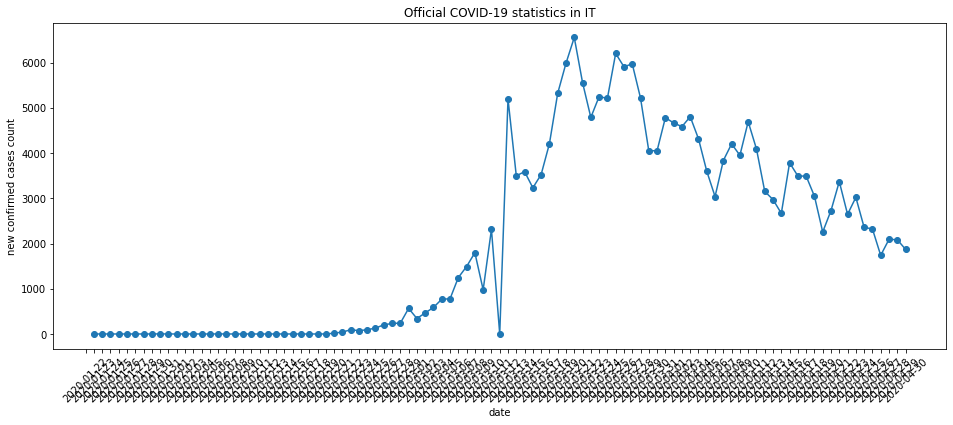

In [21]:
start_date = '8 mar 2020'
end_date = '24 mar 2020'
country = 'IT'
source = 'confirmed'

data = who_data.get_data(country, source)#, (start_date, end_date), cumulative=False)

plt.figure(figsize=(16, 6))
plt.plot(data, 'o-')

plt.title(f'Official COVID-19 statistics in {country}')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel(f'new {source} cases count')

plt.show()